# Neural Network Modeling with MULTFS

#### Overview:
This notebook aims to provided an example of training a PyTorch Model on a premade task dataset
- Text-embedder: ```all-mpnet-base-v2 (pretrained Sentence Transformer)```
- Image-embedder: ```vit_b_16 (pretrained Vision Transformer)``` 
- Decoder/Classifier: Transformer Decoder only Model trained on both text and image embeddings to out put action class


#### Datasets/Training:
- In this notebook we use pre-saved and generated datasets
    - *See the ..._dataset_gen.ipynb notebooks for how to generate and save a dataset*




### Imports

In [16]:
import sys
sys.path.append('../')

import numpy as np
import os
from PIL import Image
import json
import math
import copy
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torchvision
from tqdm.notebook import tqdm

from cognitive.task_bank import CompareLocTemporal
from cognitive import task_generator as tg
from cognitive import constants as const
from cognitive import stim_generator as sg
from cognitive import info_generator as ig
import random

### Constants

In [57]:
TRAIN_DIR = '../datasets/train_2'  # Training Dataset Directory
VAL_DIR = '../datasets/val_2'  # Validation Dataset Directory
TEST_DIR = '../datasets/test'  # Testing Dataset Directory
LM_PATH = 'offline_models/all-mpnet-base-v2'
IMGM_PATH = 'offline_models/resnet/resnet'
EMB_DIR = '../datasets/embeddings'
BATCH_SIZE = 16
MAX_FRAMES = 2  # the max possible frames across tasks
IMGM_OUT_DIM = 2048 # vision transformer output dimension
LM_OUT_DIM = 768 # language model output dimension

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(device)

cuda


# Datasets
- Read in the pregenerated task trials organized into frames, instructions, and correct actions. 

In [18]:
def read_trials(path):
    frames = []
    infos = []

    for trial_fp in os.listdir(path):
        if 'trial' not in trial_fp:
            continue

        trial_fp = os.path.join(path, trial_fp)
        imgs = []
        info = None
        
        for fp in os.listdir(trial_fp):
            fp = os.path.join(trial_fp, fp)
            
            if fp[-4:] == '.png':
                img = np.rollaxis(np.array(Image.open(fp), dtype=np.float32),2,0)
                imgs.append(img)
            elif 'trial_info' in fp:
                info = json.load(open(fp))
                infos.append(info)
                
        if len(imgs) > MAX_FRAMES:
            raise Exception(trial_fp + " contains more frames than the set maximum (MAX_FRAMES) !!!")
        elif len(imgs) != len(info['answers']):
            raise Exception(trial_fp + " numbers of frames does not match number of actions")
            
        frames.append(np.array(imgs))

    return frames, infos

train_frames, train_infos = read_trials(TRAIN_DIR)
val_frames, val_infos = read_trials(VAL_DIR)

In [19]:
train_ins = [x['instruction'] for x in train_infos]
train_raw_targets = [x['answers'] for x in train_infos]

val_ins = [x['instruction'] for x in val_infos]
val_raw_targets = [x['answers'] for x in val_infos]

### Encode Target Actions
- Encodes the target actions into one hot encoding vectors corresponding to the actions ```true, false, and null```

In [20]:
action_map = {'true': 0, 'false': 1}

def map_actions(amap, raw_actions):
    count = {'true': 0, 'false': 0}
    target_actions = []

    for actions in raw_actions:
        encoded = []
        count[actions[-1]] += 1
        encoded.append(amap[actions[1]])
        target_actions.append(np.array(encoded))
    
    return target_actions, count

train_targets, train_targets_count = map_actions(action_map, train_raw_targets)
val_targets, val_targets_count = map_actions(action_map, val_raw_targets)

print(train_targets_count)
print(val_targets_count)

{'true': 2022, 'false': 1978}
{'true': 297, 'false': 303}


In [21]:
train_targets_count
val_targets_count

{'true': 297, 'false': 303}

## Instruction Dataset

In [22]:
class InstructionsDataset(Dataset):
  """
    Pytorch Dataset class to load the Instructions Data

    Data members:
      instructions: list of instructions
      n_ins: number of instructions in the dataset

    Member functions:
      __init__: ctor
      __len__: returns n_ins
      __getitem__: returns an instruction
  """

  def __init__(self, x):

    self.instructions = x

    self.n_ins = len(self.instructions)

    return

  def __len__(self):
    """
      Returns number of instructions in the Dataset
    """

    return self.n_ins

  def __getitem__(self, idx):
    """
      Given an index return a instruction at that index
    """

    return self.instructions[idx]

In [23]:
class InstructionsCollator(object):
  """
    Data Collator used for GPT2 in a classificaiton tasks

    Args:
      use_tokenizer :
        Transformer type tokenizer used to process raw text into numbers.

    Data members:
      use_tokenizer: Tokenizer to be used inside the class.

    Member functions:
      __init__: ctor
      __call__: tokenize input

    """

  def __init__(self, use_tokenizer):

    self.use_tokenizer = use_tokenizer

    return

  def __call__(self, instructions):
    """
        Tokenizes input
    """

    # Call tokenizer
    inputs = self.use_tokenizer(instructions, padding=True, truncation=True, return_tensors='pt').to(device)

    return inputs


In [24]:
# Pretrained Language Model and Tokenizer 
# lm_encoder = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2').to(device).eval()
# tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')

# Uncomment for offline load of lang embedder
lm_encoder = AutoModel.from_pretrained('offline_models/all-mpnet-base-v2').to(device).eval()
tokenizer = AutoTokenizer.from_pretrained('offline_models/all-mpnet-base-v2')

# Create data collator to encode text and labels into numbers.
InstructionsCollator = InstructionsCollator(use_tokenizer=tokenizer)

# Create pytorch datasets for instructions
ins_train_dataset = InstructionsDataset(train_ins)
ins_val_dataset = InstructionsDataset(val_ins)

# Move pytorch datasets into dataloaders
ins_train_dataloader = DataLoader(ins_train_dataset, batch_size=1, shuffle=False, collate_fn=InstructionsCollator)
ins_val_dataloader = DataLoader(ins_val_dataset, batch_size=1, shuffle=False, collate_fn=InstructionsCollator)


## Frames Dataset

In [25]:
class FramesDataset(Dataset):
  """
    Pytorch Dataset class to load the Frame Data

    Data members:
      frames``ist of frames
      n_imgs: number of iamges in the dataset

    Member functions:
      __init__: ctor
      __len__: returns n_imgs
      __getitem__: returns an frame
  """

  def __init__(self, x):

    self.frames = x

    self.n_imgs = len(self.frames)

    return

  def __len__(self):
    """
      Returns number of frames in the Dataset
    """

    return self.n_imgs

  def __getitem__(self, idx):
    """
      Given an index return a frame
    """

    return torch.tensor(self.frames[idx]).to(device)

In [26]:
# Create pytorch datasets for instructions
frames_train_dataset = FramesDataset(train_frames)
frames_val_dataset = FramesDataset(val_frames)

# Move pytorch datasets into dataloaders
frames_train_dataloader = DataLoader(frames_train_dataset, batch_size=1, shuffle=False)
frames_val_dataloader = DataLoader(frames_val_dataset, batch_size=1, shuffle=False)


In [27]:
# from torchsummary import summary

# list(img_encoder.named_children())[-2]
# summary(torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT), input_size=(3, 224, 224))

# Language Encoder

### Language Embedder

In [28]:
def lm_embedder(instruction, encoder):
    #Mean Pooling - Take attention mask into account for correct averaging
    def mean_pooling(model_output, attention_mask):
        token_embeddings = model_output[0] # First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    # Compute token embeddings
    with torch.no_grad():
        lm_output = encoder(**instruction)

    # Perform pooling
    sentence_embeddings = mean_pooling(lm_output, instruction['attention_mask'])
    
    # Normalize embeddings
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        
    return sentence_embeddings.repeat(MAX_FRAMES,1)

# Image Encoder

### Image Embedder
- We pad frames based on max possible

In [29]:
# def img_embedder(frames, encoder):
#     activation = {}
#     def get_activation(name):
#         def hook(model, input, output):
#             activation[name] = output.detach()
#         return hook
    
#     encoder.avgpool.register_forward_hook(get_activation('layer'))

#     with torch.no_grad():
#         encoder(torch.tensor(frames))
#         out = torch.squeeze(activation['layer']) #torch.flatten(, start_dim=1, end_dim=2)
#         out = F.normalize(out, dim=1)

#     return out

def img_embedder(frames, encoder):
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    
    encoder.avgpool.register_forward_hook(get_activation('layer'))

    with torch.no_grad():
        out = encoder(torch.tensor(frames).to(device))
        out = torch.squeeze(activation['layer']) #torch.flatten(, start_dim=1, end_dim=2)
        out = F.normalize(out, dim=1).flatten()
    return out.cpu().numpy()

# Create Embeddings

In [30]:

# train_lm_embeddings = []
# train_img_embeddings = []

# val_lm_embeddings = []
# val_img_embeddings = []

# for train_i,train_f in zip(ins_train_dataloader,frames_train_dataloader):
#     train_f = train_f[0]

#     train_lm_embeddings.append(lm_embedder(train_i, lm_encoder).cpu())
#     train_img_embeddings.append(img_embedder(train_f, img_encoder).cpu())

# for val_i,val_f in zip(ins_val_dataloader,frames_val_dataloader):
#     val_f = val_f[0]

#     val_lm_embeddings.append(lm_embedder(val_i, lm_encoder).cpu())
#     val_img_embeddings.append(img_embedder(val_f, img_encoder).cpu())

# Pretrained Vision Transformer
# img_encoder = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.DEFAULT).to(device)
# img_encoder = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(device).eval()

# Uncommnent for offline load of vit
img_encoder = torch.load(IMGM_PATH, map_location=device).to(device)

img_encoder.eval()

# train_frames = np.load('../datasets/train_frames.npy') 
# val_frames = np.load('../datasets/val_frames.npy')
# train_targets = np.load('../datasets/train_targets.npy')
# val_targets = np.load('../datasets/val_targets.npy')

train_img_embeddings = []
val_img_embeddings = []

for train_f in train_frames:             
    train_img_embeddings.append(img_embedder(train_f, img_encoder))

for val_f in val_frames:
    val_img_embeddings.append(img_embedder(val_f, img_encoder))


# Embeddings Dataset

In [31]:
class EmbeddingsDataset(Dataset):
  """
    Pytorch Dataset class to load the embedded data

    Data members:
      lm_embeddings: list of language model embeddings
      img_embeddings: list of language model embeddings
      n_embs: number of embeddings in the dataset

    Member functions:
      __init__: ctor
      __len__: returns n_ins
      __getitem__: returns an instruction
  """

  def __init__(self, lm_embeddings, img_embeddings, actions):

    self.lm_embeddings = lm_embeddings
    self.img_embeddings = img_embeddings
    self.actions = actions

    self.n_embs = len(self.img_embeddings)

    return

  def __len__(self):
    """
      Returns number of instructions in the Dataset
    """

    return self.n_embs

  def __getitem__(self, idx):
    """
      Given an index return a instruction at that index
    """

    return {'frames':self.img_embeddings[idx].to(device), 'actions':torch.tensor(self.actions[idx], dtype=torch.float32, device=device)}

In [32]:
# # Create pytorch dataset for train, val, test data
# train_dataset = EmbeddingsDataset(train_lm_embeddings, train_img_embeddings, train_targets)
# val_dataset = EmbeddingsDataset(val_lm_embeddings, val_img_embeddings, val_targets)

# # Move pytorch datasets into dataloaders
# train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [33]:
# train_embs = [np.array(x.flatten()) for x in train_img_embeddings] 
# val_embs = [np.array(x.flatten()) for x in val_img_embeddings]
# train_targs = [np.array(x) for x in train_targets]
# val_targs = [np.array(x) for x in val_targets]

In [34]:
# train_embs = np.load('../datasets/train_embs.npy') 
# val_embs = np.load('../datasets/val_embs.npy') 
# train_targs = np.load('../datasets/train_targets.npy')
# val_targs = np.load('../datasets/val_targets.npy')

In [35]:
# CHECKING SVC ABILITY TO CLASSIFY

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
train_frames_embs = sc.fit_transform(train_img_embeddings)
val_frames_embs = sc.transform(val_img_embeddings)

In [ ]:
# Step 3: Create an SVM classifier
# You can choose different types of SVM (linear, rbf, polynomial, etc.) by changing the kernel parameter.
# C is the regularization parameter; you can adjust it for your specific problem.
svm_classifier = SVC(kernel='rbf', C=1.5, cache_size=8000, gamma='scale')

# Step 4: Train the SVM classifier on the training data
svm_classifier.fit(train_frames_embs, train_targets)

# Step 5: Make predictions on the test data
y_pred = svm_classifier.predict(val_frames_embs)

# Step 6: Evaluate the model
accuracy = accuracy_score(val_targets, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

/home/lucasg/mlti-env/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 80.00%


In [105]:
train_embs = [torch.Tensor(x) for x in train_frames_embs]
val_embs = [torch.Tensor(x) for x in val_frames_embs]

array([0])

In [106]:
# Create pytorch dataset for train, val, test data
train_dataset = EmbeddingsDataset(None, train_embs, train_targets)
val_dataset = EmbeddingsDataset(None, val_embs, val_targets)

# Move pytorch datasets into dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [107]:
test_t_e = []
test_t_a = []
test_v_e = []
test_v_a = []

for x in train_dataloader:
    for y in x['frames']:
        test_t_e.append(y.cpu().numpy())
    for z in x['actions']:
        test_t_a.append(z.cpu().numpy())
                                           
for x in val_dataloader:
    for y in x['frames']:
        test_v_e.append(y.cpu().numpy()) 
    for z in x['actions']:
        test_v_a.append(z.cpu().numpy())

array([0.], dtype=float32)

In [108]:
# Step 3: Create an SVM classifier
# You can choose different types of SVM (linear, rbf, polynomial, etc.) by changing the kernel parameter.
# C is the regularization parameter; you can adjust it for your specific problem.
svm_classifier = SVC(kernel='rbf', C=1.5, cache_size=8000, gamma='scale')

# Step 4: Train the SVM classifier on the training data
svm_classifier.fit(test_t_e, test_t_a)

# Step 5: Make predictions on the test data
y_pred = svm_classifier.predict(test_v_e)

# Step 6: Evaluate the model
accuracy = accuracy_score(test_v_a, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

/home/lucasg/mlti-env/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 80.00%


# Action Decoder

In [109]:
from matplotlib import projections
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.utils.data import dataset

class CausalMatchTransformer(nn.Module):
    """
    Pytorch based transformer decoder model
    """

    # Initialize Model with Params
    def __init__(self, nframes=MAX_FRAMES, blocks=3, nhead=5, emb_dim=IMGM_OUT_DIM, classes=3, device=device):
        super().__init__()

        # Device
        self.device = device

        # Embedding Dimension
        self.emb_dim = emb_dim

        # Number of frames
        self.nframes = nframes

        # Frame Position Embedder Layer
        # self.pos_emb = nn.Parameter(torch.Tensor(nframes,emb_dim)).to(device)
        # torch.nn.init.xavier_uniform_(
        #    self.pos_emb,
        #    gain=torch.nn.init.calculate_gain("linear"))
        # self.pos_emb = PositionalEncoding(emb_dim, 0)

        # Instruction Dim Projection Layer
        # self.lm_linear_layer = nn.Linear(LM_OUT_DIM, emb_dim).to(device)
        
        # self.img_linear_layer = nn.Linear(IMGM_OUT_DIM, emb_dim)

        # Decoder Layers
        # self.decoder_layer = nn.TransformerDecoderLayer(d_model=emb_dim, nhead=nhead, batch_first=True).to(device)
        # self.decoder_layers = _get_clones(self.decoder_layer, blocks)
        
        # self.encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=nhead, batch_first=True).to(device)
        # self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=blocks).to(device)
        
        # Decoder
        # self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=blocks).to(device)
        
        self.mlp = nn.Sequential(
                        nn.Linear(emb_dim, 100),
                        nn.ReLU(),
                        nn.Linear(100,2)
                        # nn.Linear(50, 128),
                        # nn.ReLU(),

                        # nn.Linear(128, 64),
                        # nn.ReLU(),
                        # nn.Linear(64,2)
                    )
        
        # self.linear = nn.Linear(emb_dim, 224)
        # Action classifier
        # self.classifier = nn.Linear(emb_dim, classes).to(device)

    # Function for forward pass
    def forward(self, instruction, frames, mask, padding_mask):

        # Project instruction embedding
        # instruction = self.lm_linear_layer(instruction)
        
        # frames = self.img_linear_layer(frames)

        # Add the frame position embedding
        # for i in range(len(frames)):
        #     frames[i] += self.pos_emb[i,:]
        # frames = self.pos_emb(frames)

        # output = self.encoder(frames)#, memory_mask=mask, memory_key_padding_mask=padding_mask, )
        # output = self.decoder(frames, instruction)
        
#         output = output[:,-1,:]
        # output = output.mean(dim=1)

        # Pass through linear layer for classification
        # output = self.linear(frames)
        # output = output.mean(dim=1)
        # output = self.classifier(output)
        
        output= self.mlp(frames)

        return output
 
# Creates a list of torch duplicate torch modules
def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

# Creates a square Sequential/Causal mask of size sz
def generate_causal_mask(sz: int) -> Tensor:
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

# Generates a padding masks for each sequence in a batch
def generate_pad_mask(batch):

    pad_tensor = torch.ones((batch.shape[2])).to(device)

    mask = np.zeros((batch.shape[0],batch.shape[1]))

    for s in range(0, batch.shape[0]):
        for v in range(0, batch[s].shape[0]):
            new_s = torch.all(batch[s][v] == pad_tensor)
            mask[s][v] = new_s
    return torch.tensor(mask).bool().to(device)

class PositionalEncoding(nn.Module):
    # Positional encoding module taken from PyTorch Tutorial
    # Link: https://pytorch.org/tutorials/beginner/transformer_tutorial.html

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [110]:
torch.cuda.empty_cache()
model = CausalMatchTransformer(nframes=1,
                               blocks=1,
                               nhead=4,
                               emb_dim=IMGM_OUT_DIM*2,
                               classes=len(action_map.keys()),
                               device=device).float().to(device)



# Training

## Pre-generated

In [111]:
# Training configurations
epochs = 10
# weights = [4, 4, 0.5]
# class_weights = torch.FloatTensor(weights)
# criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')
criterion = nn.CrossEntropyLoss()

lr = 1e-6
optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), lr=lr)

mask = generate_causal_mask(MAX_FRAMES).to(device)

In [ ]:
# Training and validation loop

# Store the average loss after each epoch
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

print("starting")
for epoch in range(epochs):
    print(f"epoch={epoch}")

    # Epoch stat trackers
    # epoch_null_loss = 0
    # epoch_non_null_loss = 0
    # epoch_correct_null = 0
    # epoch_correct_non_null = 0
    # epoch_count_null = 0
    # epoch_count_non_null = 0
    # epoch_count = 0
    
    epoch_correct = 0
    epoch_count = 0
    epoch_loss = 0
    
    for idx, batch in enumerate(iter(train_dataloader)):

        # Inputs and Targets
        instructions =  None #batch['instructions']
        frames = batch['frames']
        targets = batch['actions']
        

        # Frame Padding
        padding_mask = None #generate_pad_mask(batch=frames)
        # pad_indexes = np.argwhere(np.array(padding_mask.cpu()) == True)[:,1]
        # pad_indexes = MAX_FRAMES if len(pad_indexes) == 0 else pad_indexes
        
        # Get predictions
        predictions = model(instructions, frames, mask, padding_mask)
        
        # Get Loss for both null and non-null actions
        # non_null_loss = criterion(predictions, targets.long())
        # null_loss, non_null_loss, scale = loss(predictions, targets.long())
        # total_loss = null_loss*scale + non_null_loss*(1/scale)
        total_loss = criterion(predictions, targets.squeeze(1).long())

        # Track stats
        correct = predictions.argmax(dim=-1) == targets.squeeze(1)
        
        epoch_correct += correct.sum().item()
        epoch_count += correct.size(0)
        epoch_loss += total_loss.item()
    
 
#         epoch_correct_non_null += (predictions.argmax(dim=-1).cpu() == targets.cpu()).sum().item()
#         epoch_count_non_null += (predictions.argmax(dim=-1).cpu() == targets.cpu()).size(0)
        
#         correct_counts = correct(predictions.argmax(dim=-1).cpu(), targets.cpu())
#         epoch_correct_null += correct_counts[0]
#         epoch_count_null += correct_counts[1]
#         epoch_correct_non_null += correct_counts[2]
#         epoch_count_non_null += correct_counts[3]
        
        # epoch_null_loss += null_loss.item()
        # epoch_non_null_loss += non_null_loss.item()

        # Backward pass
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
        
    # Validate on validation set every 5 epochs
    if (epoch+1) % 2 == 0 or epoch == epochs:
        
        # Turn off gradient calcs
        with torch.no_grad():
            # print(torch.norm(model.encoder.layers[-1].linear2.weight.grad))
            # val_epoch_null_loss = 0
            # val_epoch_non_null_loss = 0 
            # val_epoch_correct_null = 0
            # val_epoch_correct_non_null = 0
            # val_epoch_count_null = 0
            # val_epoch_count_non_null = 0
            val_epoch_correct = 0
            val_epoch_count = 0
            val_epoch_loss = 0
            
            for idx, batch in enumerate(iter(val_dataloader)):
                # Inputs and Targets
                instructions = None # batch['instructions']
                frames = batch['frames']
                targets = batch['actions']

                # Frame Padding
                padding_mask = None # generate_pad_mask(batch=frames)
                #pad_indexes = np.argwhere(np.array(padding_mask.cpu()) == True)[:,1]
                #pad_indexes = MAX_FRAMES if len(pad_indexes) == 0 else pad_indexes

                # Get predictions
                predictions = model(instructions, frames, mask, padding_mask)

                # Get Losses
                # non_null_loss = criterion(predictions, targets.long())
                # null_loss, non_null_loss, scale = loss(predictions, targets.long())
                # total_loss = null_loss*scale + non_null_loss*(1/scale)

                total_loss = criterion(predictions, targets.squeeze(1).long())
                
                
                # Track Stats
                correct = predictions.argmax(dim=-1) == targets.squeeze(1)
        
                val_epoch_correct += correct.sum().item()
                val_epoch_count += correct.size(0)
                val_epoch_loss += total_loss.item()

                # val_epoch_correct_non_null += (predictions.argmax(dim=-1).cpu() == targets.cpu()).sum().item()
                # val_epoch_count_non_null += (predictions.argmax(dim=-1).cpu() == targets.cpu()).size(0)
                # val_correct_counts = correct(predictions.argmax(dim=-1).cpu(), targets.cpu())
                # val_epoch_correct_null += val_correct_counts[0]
                # val_epoch_count_null += val_correct_counts[1]
                # val_epoch_correct_non_null += val_correct_counts[2]
                # val_epoch_count_non_null += val_correct_counts[3]

                # val_epoch_null_loss += null_loss.item()
                # val_epoch_non_null_loss += non_null_loss.item()
            

        # Track loss and acc ever 5 epochs
        avg_train_loss = epoch_loss / len(train_dataloader)
        avg_val_loss = val_epoch_loss / len(val_dataloader)
        
        all_loss['train_loss'].append(round(avg_train_loss,4))
        all_loss['val_loss'].append(round(avg_val_loss,4))
        
        all_acc['val_acc'].append(round(val_epoch_correct / val_epoch_count,4))
        all_acc['train_acc'].append(round(epoch_correct / epoch_count,4))
        
        
        # avg_train_null_loss = epoch_null_loss / len(train_dataloader)
        # avg_train_non_null_loss = epoch_non_null_loss / len(train_dataloader)
        # avg_val_null_loss = val_epoch_null_loss / len(val_dataloader)
        # avg_val_non_null_loss = val_epoch_non_null_loss / len(val_dataloader)
        
        # all_loss['val_null_loss'].append(round(avg_val_null_loss,4))
        # all_loss['val_non_null_loss'].append(round(avg_val_non_null_loss,4))
        # all_acc['val_null_acc'].append(round(val_epoch_correct_null / val_epoch_count_null,4))
        # all_acc['val_non_null_acc'].append(round(val_epoch_correct_non_null / val_epoch_count_non_null,4))
        
        # all_loss['train_null_loss'].append(round(avg_train_null_loss,4))
        # all_loss['train_non_null_loss'].append(round(avg_train_non_null_loss,4))
        # all_acc['train_null_acc'].append(round(epoch_correct_null / epoch_count_null,4))
        # all_acc['train_non_null_acc'].append(round(epoch_correct_non_null / epoch_count_non_null,4))

        print(all_acc['train_acc'][-1])
        print(all_acc['val_acc'][-1])

starting
epoch=0
epoch=1
0.5122
0.5117
epoch=2
epoch=3
0.5282
0.5217
epoch=4
epoch=5
0.5445
0.5333
epoch=6
epoch=7


In [46]:
import matplotlib.pyplot as plt

def plot_dict(dict_arrays, use_xlabel='Epochs', use_ylabel='Value', use_title=None):
    # Font size select custom or adjusted on `magnify` value.
    font_size = np.interp(0.1, [0.1,1], [10.5,50])

    # Font variables dictionary. Keep it in this format for future updates.
    font_dict = dict(
        family='DejaVu Sans',
        color='black',
        weight='normal',
        size=font_size,
        )

    # Single plot figure.
    plt.subplot(1, 2, 1)

    # Use maximum length of steps. In case each arrya has different lengths.
    max_steps = []

    # Plot each array.
    for index, (use_label, array) in enumerate(dict_arrays.items()):
        # Set steps plotted on x-axis - we can use step if 1 unit has different value.
        if 0 > 0:
            # Offset all steps by start_step.
            steps = np.array(range(0, len(array))) * 1 + 0
            max_steps = steps if len(max_steps) < len(steps) else max_steps
        else:
            steps = np.array(range(1, len(array) + 1)) * 1
            max_steps = steps if len(max_steps) < len(steps) else max_steps

        # Plot array as a single line.
        plt.plot(steps, array, linestyle=(['-'] * len(dict_arrays))[index], label=use_label)

        # Plots points values.
        if ([False] * len(dict_arrays))[index]:
            # Loop through each point and plot the label.
            for x, y in zip(steps, array):
                # Add text label to plot.
                plt.text(x, y, str(round(y, 3)), fontdict=font_dict)

    # Set horizontal axis name.
    plt.xlabel(use_xlabel, fontdict=font_dict)

    # Use x ticks with steps or labels.
    plt.xticks(max_steps, None, rotation=0)

    # Set vertical axis name.
    plt.ylabel(use_ylabel, fontdict=font_dict)

    # Adjust both axis labels font size at same time.
    plt.tick_params(labelsize=font_dict['size'])

    # Place legend best position.
    plt.legend(loc='best', fontsize=font_dict['size'])

    # Adjust font for title.
    font_dict['size'] *= 1.8

    # Set title of figure.
    plt.title(use_title, fontdict=font_dict)

    # Rescale `magnify` to be used on inches.
    magnify = 0.1
    magnify *= 15

    # Display grid depending on `use_grid`.
    plt.grid(True)

    # Make figure nice.
    plt.tight_layout()

    # Get figure object from plot.
    fig = plt.gcf()

    # Get size of figure.
    figsize = fig.get_size_inches()

    # Change size depending on height and width variables.
    figsize = [figsize[0] * 3 * magnify, figsize[1] * 1 * magnify]

    # Set the new figure size with magnify.
    fig.set_size_inches(figsize)

    return

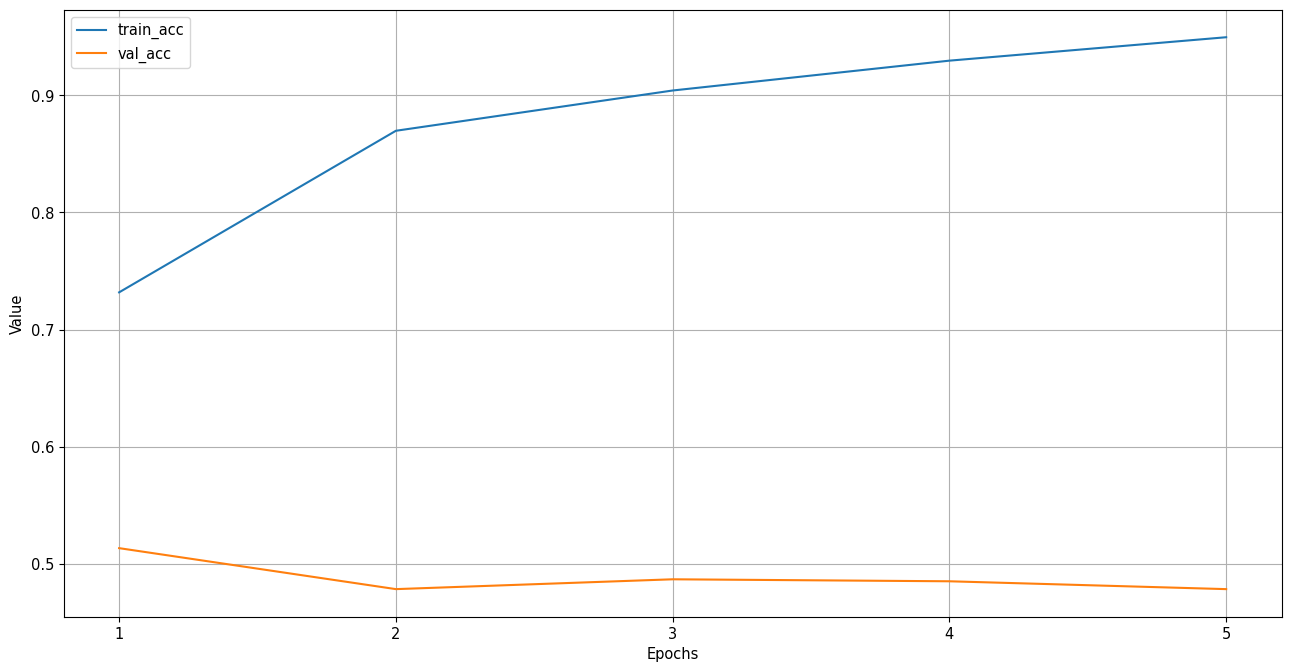

In [47]:
plot_dict(all_acc)

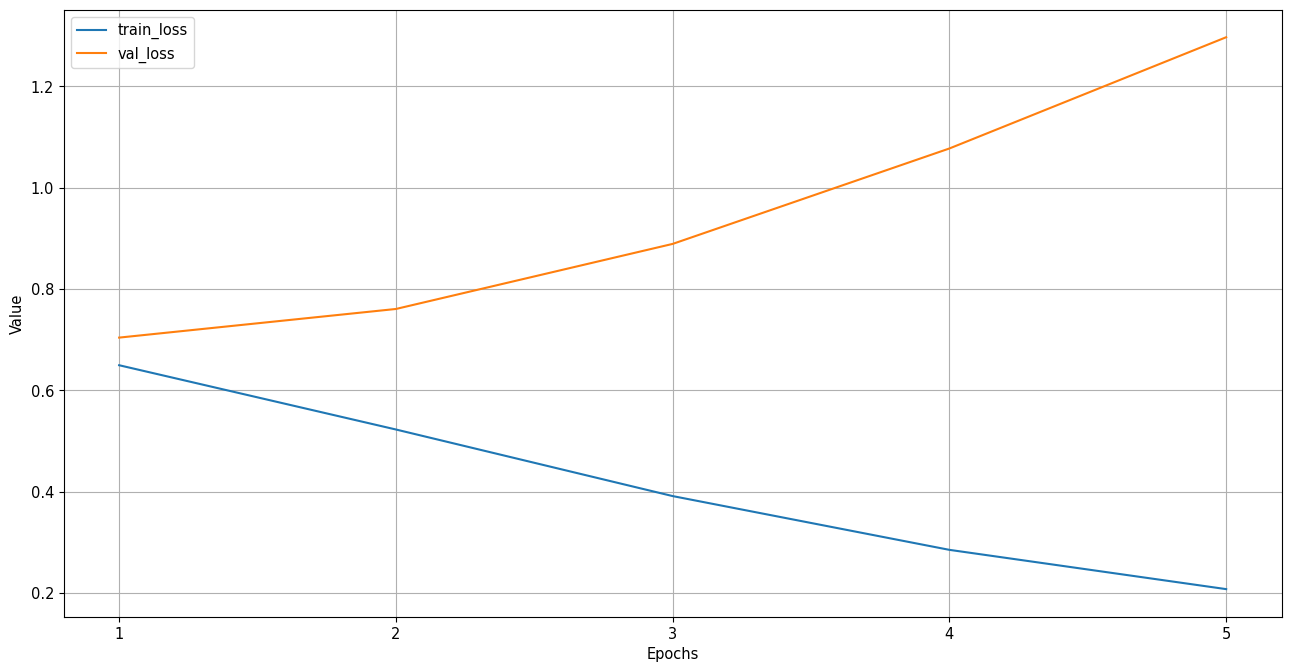

In [48]:
plot_dict(all_loss)

## Evaluating

In [33]:
model.eval()

val_epoch_correct_non_null = 0

val_epoch_count_non_null = 0

with torch.no_grad():
    test_correct_null = 0
    test_correct_non_null = 0
    test_count_null = 0
    test_count_non_null = 0

    for idx, batch in enumerate(iter(val_dataloader)):
        # Inputs and Targets
        instruction = batch['instruction']
        frames = batch['frames']
        targets = batch['actions'][:,-1]
        print(targets)

        # Frame Padding
        padding_mask = generate_pad_mask(batch=frames)
        pad_indexes = np.argwhere(np.array(padding_mask.cpu()) == False)[:,1]

        # Get predictions
        predictions = model(instruction, frames, mask, padding_mask)
        print(predictions)
        predictions = predictions[:,pad_indexes]

        # Get Losses
        non_null_loss = criterion(predictions, targets.long())
        # null_loss, non_null_loss, scale = loss(predictions, targets)
        # total_loss = non_null_loss #null_loss*scale + non_null_loss*(1/scale)
        # # total_loss = criterion(predictions.permute(0, 2, 1), targets.long())

        # Track Stats
        val_epoch_correct_non_null += (predictions.argmax(dim=-1).cpu() == targets.cpu()).sum().item()
        val_epoch_count_non_null += (predictions.argmax(dim=-1).cpu() == targets.cpu()).size(0)

print("Test Non-Null Accuracy: ", round(val_epoch_correct_non_null/val_epoch_count_non_null,4))

/tmp/ipykernel_50335/245295339.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'frames':self.img_embeddings[idx].to(device), 'actions':torch.tensor(self.actions[idx], dtype=torch.float32, device=device)}


KeyError: 'instruction'